In [5]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import pyreadr
import seaborn as sns
import copy
import itertools
from ucimlrepo import fetch_ucirepo # to import the data


import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros
from tensorflow.keras.optimizers import Adam, Nadam
import keras_tuner as kt
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.compose import make_column_transformer
from NAM_models import ActivationLayer, FeatureNN, NAM
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier
import gaminet
from gaminet import GAMINet

#-------------------------- import data --------------------------
'''Data Source: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset'''
bike_sharing = fetch_ucirepo(id = 275)
data = bike_sharing.data.features
y = bike_sharing.data.targets
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [4]:
# variable information 
bike_sharing.variables

,name,role,type,demographic,description,units,missing_values
0,instant,ID,Integer,None,record index,None,no
1,dteday,Feature,Date,None,date,None,no
2,season,Feature,Categorical,None,"1:winter, 2:spring, 3:summer, 4:fall",None,no
3,yr,Feature,Categorical,None,"year (0: 2011, 1: 2012)",None,no
4,mnth,Feature,Categorical,None,month (1 to 12),None,no
5,hr,Feature,Categorical,None,hour (0 to 23),None,no
6,holiday,Feature,Binary,None,weather day is holiday or not (extracted from ...,None,no
7,weekday,Feature,Categorical,None,day of the week,None,no
8,workingday,Feature,Binary,None,"if day is neither weekend nor holiday is 1, ot...",None,no
9,weathersit,Feature,Categorical,None,"- 1: Clear, Few clouds, Partly cloudy, Partly ...",None,no


In [100]:
# -------------------------- group variables --------------------------
embedding_vars = ["season", "mnth", "hr", "weekday", "weathersit"] # categorical variables with many levels that require embedding
binary_vars = ["yr", "holiday", "workingday"]

# remove date
X = data.drop(columns = ["dteday"]).reset_index(drop = True)

# -------------------------- train-test split --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)


# -------------------------- transform --------------------------
# define transformer - StandardScaler will be applied to all numeric variables
ct_NAM = make_column_transformer(
    (OrdinalEncoder(), ["season", "mnth", "weekday", "weathersit"]),
    remainder = "passthrough",
    verbose_feature_names_out = False
)

# fit the transformer to the data
train = ct_NAM.fit_transform(X_train)
test = ct_NAM.transform(X_test)
feature_names = ct_NAM.get_feature_names_out()  # get the columns' names
print(feature_names)

['season' 'mnth' 'weekday' 'weathersit' 'yr' 'hr' 'holiday' 'workingday'
 'temp' 'atemp' 'hum' 'windspeed']


In [101]:
# -------------------------- define a function to fit a NAM --------------------------

'''function to create a subnetwork'''
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True):
    """create a subnet with configurable layers and neurons."""
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = 1))
    model.add(Dense(1, trainable = trainable))
    model.add(Lambda(lambda x: x - tf.reduce_mean(x))) # zero center all output
    return model

In [102]:
'''model architecture'''
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# model hyperparameters
num_neurons = 10
num_layers = 1
activation = 'leaky_relu'
embedding_dim = 3

# main effect
for name in feature_names:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)
    
    if name in embedding_vars:
        # categorical variables will pass through an embedding layer
        embed_layer = Embedding(input_dim = data[name].nunique(), 
                    output_dim = embedding_dim,
                    name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (embedding_dim,))(embed_layer)
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(embed_layer_reshape)
        sub_outputs.append(sub_output)
    else:
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs.append(sub_output)

# combine subnets' outputs
subnets = Concatenate(name = f"subnet_output")(sub_outputs)
output_layer = Dense(1, activation = "exponential")(subnets)

# final model
model_main = Model(inputs = inputs, outputs = output_layer)

In [103]:
# -------------------------- compile and fit the model --------------------------

# for reproducibility
seed_value = 100
keras.utils.set_random_seed(seed_value)

# create training data consistent with the model architecture
X_train_split = []
for i in range(len(feature_names)):
    X_train_split.append(train[:, i])

# compile
model_main.compile(optimizer = "adam", loss = 'mean_squared_error', metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)

%time hist_main = model_main.fit(X_train_split, y_train, epochs = 1_000, \
    callbacks = [es], validation_split = 0.25)

Epoch 1/1000
326/326 [==============================] - 2s 2ms/step - loss: 63522.8438 - root_mean_squared_error: 252.0374 - mean_absolute_error: 180.0965 - val_loss: 54681.4883 - val_root_mean_squared_error: 233.8407 - val_mean_absolute_error: 166.2268
Epoch 2/1000
326/326 [==============================] - 0s 1ms/step - loss: 54448.0859 - root_mean_squared_error: 233.3411 - mean_absolute_error: 165.6320 - val_loss: 53764.3906 - val_root_mean_squared_error: 231.8715 - val_mean_absolute_error: 163.6408
Epoch 3/1000
326/326 [==============================] - 0s 1ms/step - loss: 54062.1250 - root_mean_squared_error: 232.5126 - mean_absolute_error: 164.8738 - val_loss: 53134.4766 - val_root_mean_squared_error: 230.5092 - val_mean_absolute_error: 162.0399
Epoch 4/1000
326/326 [==============================] - 0s 1ms/step - loss: 53290.5781 - root_mean_squared_error: 230.8475 - mean_absolute_error: 163.5696 - val_loss: 51178.2109 - val_root_mean_squared_error: 226.2260 - val_mean_absolute_

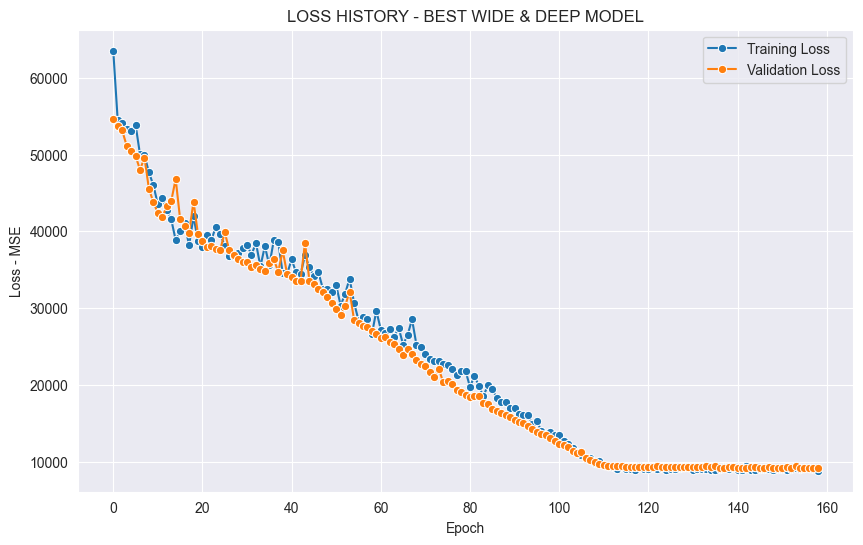

In [104]:
# plotting the loss history
plt.figure(figsize = (10, 6))
sns.set_style("darkgrid")
sns.lineplot(data = hist_main.history['loss'], label = 'Training Loss', marker = 'o')
sns.lineplot(data = hist_main.history['val_loss'], label = 'Validation Loss', marker = 'o')
plt.title('LOSS HISTORY - BEST WIDE & DEEP MODEL')
plt.xlabel('Epoch')
plt.ylabel('Loss - MSE')
plt.legend()
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.show()

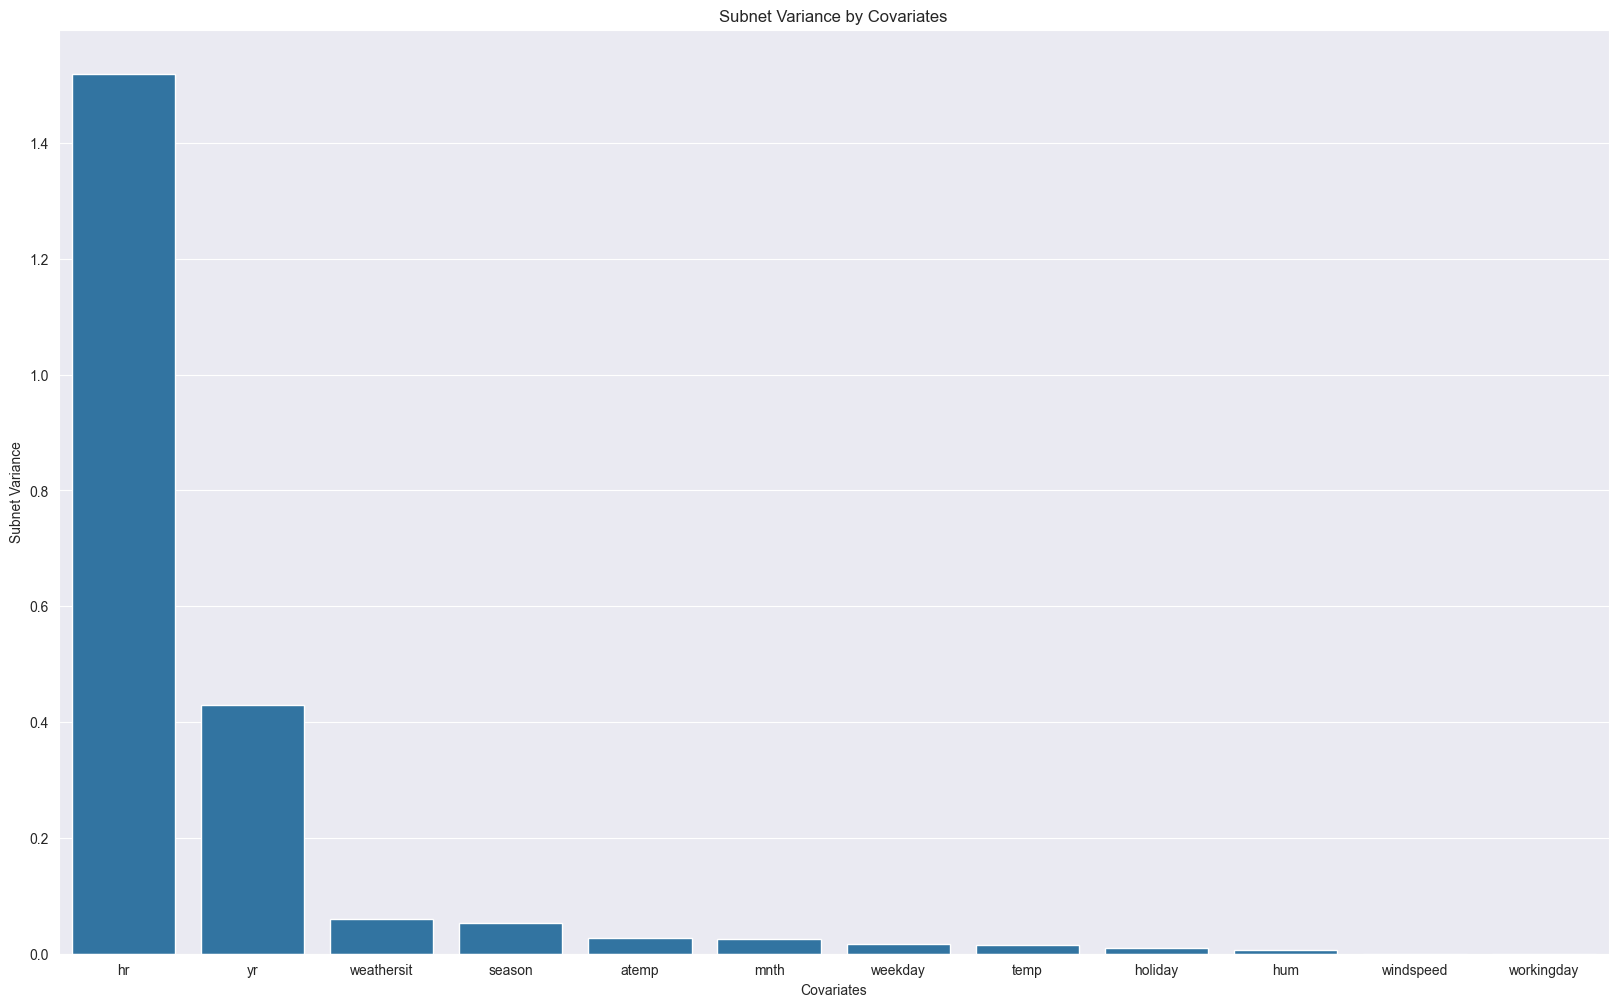

In [105]:
# -------------------------- quantify variable importance --------------------------

'''Source: https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer'''
subnet_output_layer = model_main.get_layer("subnet_output")  # Get the layer
subnet_output_function = K.function(model_main.inputs, [subnet_output_layer.output])  # create a function to produce the layer's values
subnet_output_values = subnet_output_function(X_train_split)[0] # get the subnetwork output

# get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:,i]))
covariates = [name for name in feature_names]

# -------------------------- plot the variable importance --------------------------
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (20, 12))
sns.barplot(x = "Covariates", y="Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()